In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import os
import sys
from tqdm.auto import tqdm
import pandas as pd
import networkx as nx

In [4]:
project_root = os.path.abspath(
    os.path.join("C:/Users/jllgo/OneDrive/Documentos/UFMG/MSc & MSI 2/MatchSegmentation")
)
if project_root not in sys.path:
    sys.path.append(project_root)

In [5]:
from src.pass_networks.process_intervals import load_graphs

# Get Graphs

In [6]:
PROCESSED_DATA_PATH = "../data/processed/PL-22-23"
CSV_DATA_PATH = "../data/csv"

In [7]:
games = os.listdir(PROCESSED_DATA_PATH)
game_ids = [game.split('.')[0] for game in games]
print(f"Games to process: {len(game_ids)}")

Games to process: 30


In [9]:
matches = []

for match_id in tqdm(game_ids, desc="Loading Pre-Processed Graphs", total=len(game_ids)):
    match_graphs = load_graphs(match_id, PROCESSED_DATA_PATH)
    matches.append((match_id,match_graphs))

Loading Pre-Processed Graphs:   0%|          | 0/30 [00:00<?, ?it/s]

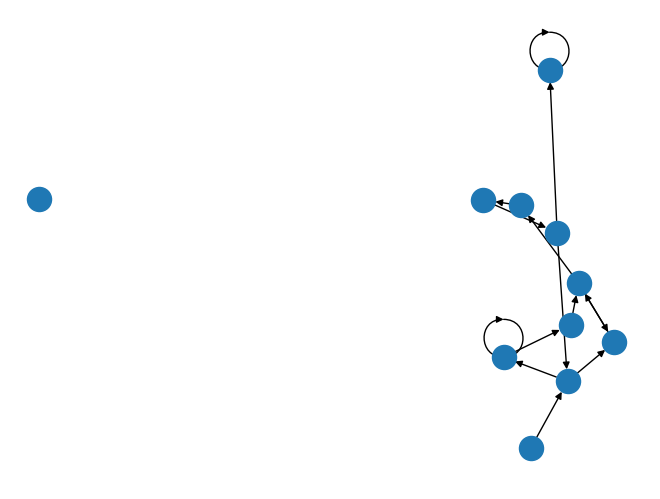

In [48]:
G = matches[0][1][0]['2']
G1 = matches[0][1][1]['7']
nx.draw(G)

# Calculate Metrics

Betweenness centrality

In [30]:
betweenness = nx.betweenness_centrality(G)
print(betweenness)

Betweenness Centrality:
{35: 0.17777777777777778, 9: 0.0, 34: 0.3111111111111111, 11: 0.3111111111111111, 7: 0.3111111111111111, 1: 0.0, 5: 0.0, 8: 0.07777777777777778, 6: 0.34444444444444444, 12: 0.07777777777777778, 4: 0.3111111111111111}


Closeness centrality

In [32]:
closeness = nx.closeness_centrality(G)
print(closeness)

{35: 0.35555555555555557, 9: 0.2076923076923077, 34: 0.26666666666666666, 11: 0.23703703703703705, 7: 0.21333333333333335, 1: 0.0, 5: 0.0, 8: 0.2206896551724138, 6: 0.3047619047619048, 12: 0.2064516129032258, 4: 0.23703703703703705}


Network density

In [33]:
density = nx.density(G)
print(density)


Network Density:
0.12727272727272726


Average path length 

In [38]:
# Definir o nó-alvo
target = 12

# Calcular o caminho mais curto de todos os nós para o nó-alvo
shortest_paths = []
for node in G.nodes:
    try:
        path_length = nx.shortest_path_length(G, source=node, target=target)
        shortest_paths.append(path_length)
    except nx.NetworkXNoPath:
        # Caso não haja caminho, ignore (ou use um valor especial, como float('inf'))
        continue

# Calcular a média dos caminhos (ignorar os sem caminho)
if shortest_paths:
    average_path_to_target = sum(shortest_paths) / len(shortest_paths)
    print(f"Caminho médio para o nó {target}: {average_path_to_target}")
else:
    print(f"Não há caminhos para o nó {target}.")

Caminho médio para o nó 12: 3.4444444444444446


Feed-forward loop (FFL) metric

In [34]:
def count_ffl(graph):
    ffl_count = 0
    for node in graph.nodes:
        # Encontrar sucessores e predecessores
        successors = set(graph.successors(node))
        for succ in successors:
            second_order_succ = set(graph.successors(succ))
            # Contar casos onde o terceiro nó fecha o FFL
            ffl_count += len(second_order_succ & successors)
    return ffl_count

ffl = count_ffl(G)
print("Feed-Forward Loops (FFL):", ffl)

Feed-Forward Loops (FFL): 5


Assortatividade

In [ ]:
print("Assortativity Coefficient:", nx.degree_assortativity_coefficient(G))

Assortativity Coefficient: 0.0912870929175294


Modularity

In [41]:
from networkx.algorithms.community import modularity, greedy_modularity_communities

communities = list(greedy_modularity_communities(G))
modularity_score = modularity(G, communities)
print("Modularity:", modularity_score)

Modularity: 0.4


Número de Componentes Fortemente Conectados

In [42]:
strongly_connected_components = list(nx.strongly_connected_components(G))
print("Number of Strongly Connected Components:", len(strongly_connected_components))

Number of Strongly Connected Components: 4


Conectividade 

In [43]:
node_connectivity = nx.node_connectivity(G)
edge_connectivity = nx.edge_connectivity(G)
print("Node Connectivity:", node_connectivity)
print("Edge Connectivity:", edge_connectivity)


Node Connectivity: 0
Edge Connectivity: 0


transitividade

In [45]:
transitivity = nx.transitivity(G)
print("Transitivity:", transitivity)


Transitivity: 0


Motivos

In [46]:
from networkx.algorithms import motifs

# Detectar motivos simples
triadic_census = nx.triadic_census(G)
print("Triadic Census:", triadic_census)


ImportError: cannot import name 'motifs' from 'networkx.algorithms' (c:\Users\jllgo\OneDrive\Documentos\UFMG\MSc & MSI 2\MatchSegmentation\.venv\Lib\site-packages\networkx\algorithms\__init__.py)

# Graph Distance

In [49]:
ged = nx.graph_edit_distance(G, G1)
print("Graph Edit Distance:", ged)

Graph Edit Distance: 6.0


In [50]:
from scipy.stats import wasserstein_distance

# Obter distribuições de grau
degrees_G1 = [deg for _, deg in G.degree()]
degrees_G2 = [deg for _, deg in G1.degree()]

# Calcular similaridade com a distância de Wasserstein (Earth Mover's Distance)
degree_similarity = wasserstein_distance(degrees_G1, degrees_G2)
print("Degree Distribution Similarity (Wasserstein Distance):", degree_similarity)


Degree Distribution Similarity (Wasserstein Distance): 0.36363636363636365


In [51]:
from collections import Counter

# Calcular distribuições de comprimento de caminhos mais curtos
def shortest_path_distribution(graph):
    lengths = []
    for node in graph.nodes:
        paths = nx.single_source_shortest_path_length(graph, node)
        lengths.extend(paths.values())
    return Counter(lengths)

dist_G1 = shortest_path_distribution(G)
dist_G2 = shortest_path_distribution(G1)

print("Shortest Path Distribution G1:", dist_G1)
print("Shortest Path Distribution G2:", dist_G2)


Shortest Path Distribution G1: Counter({2: 14, 3: 14, 1: 12, 4: 12, 5: 12, 0: 11, 6: 7, 7: 2})
Shortest Path Distribution G2: Counter({2: 13, 0: 11, 1: 11, 3: 9, 4: 5, 5: 2})


In [52]:
from numpy import cumsum

# Função para calcular Delta-Convergence
def delta_convergence(dist1, dist2):
    keys = set(dist1.keys()).union(dist2.keys())
    cdf1 = cumsum([dist1.get(k, 0) for k in sorted(keys)])
    cdf2 = cumsum([dist2.get(k, 0) for k in sorted(keys)])
    return sum(abs(cdf1 - cdf2))

delta = delta_convergence(dist_G1, dist_G2)
print("Delta-Convergence:", delta)


Delta-Convergence: 112


In [53]:
density_G1 = nx.density(G)
density_G2 = nx.density(G1)

print("Density G1:", density_G1)
print("Density G2:", density_G2)
print("Density Similarity (Absolute Difference):", abs(density_G1 - density_G2))


Density G1: 0.12727272727272726
Density G2: 0.10909090909090909
Density Similarity (Absolute Difference): 0.018181818181818174


In [54]:
clustering_G1 = nx.average_clustering(G1)
clustering_G2 = nx.average_clustering(G)

print("Clustering Coefficient G1:", clustering_G1)
print("Clustering Coefficient G2:", clustering_G2)
print("Clustering Coefficient Similarity (Absolute Difference):", abs(clustering_G1 - clustering_G2))


Clustering Coefficient G1: 0.13787878787878788
Clustering Coefficient G2: 0.0
Clustering Coefficient Similarity (Absolute Difference): 0.13787878787878788


In [55]:
from networkx.algorithms.community import greedy_modularity_communities, modularity

# Detectar comunidades
communities_G1 = list(greedy_modularity_communities(G1))
communities_G2 = list(greedy_modularity_communities(G))

# Calcular modularidade
modularity_G1 = modularity(G1, communities_G1)
modularity_G2 = modularity(G, communities_G2)

print("Modularity G1:", modularity_G1)
print("Modularity G2:", modularity_G2)
print("Modularity Similarity (Absolute Difference):", abs(modularity_G1 - modularity_G2))


Modularity G1: 0.4186851211072664
Modularity G2: 0.4
Modularity Similarity (Absolute Difference): 0.01868512110726639
